In [3]:
# Imports do notebook

import numpy as np
from numpy import matlib as matlab
from numpy.fft import fft
import math
from scipy.signal import lfilter as filter
import scipy.signal as signal
import matplotlib.pyplot as plt

import pandas as pd

import sounddevice as sd

# Trecho pra permitir gráficos interativos... (vai instalar um pacote)
#!pip install -q mpld3
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

ModuleNotFoundError: ignored

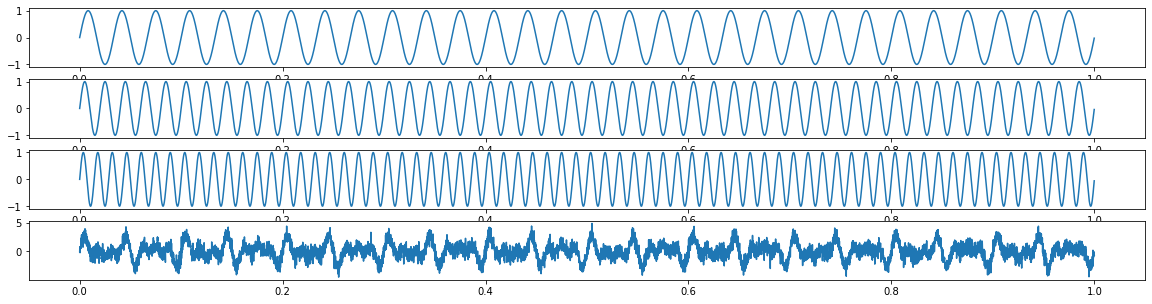

In [6]:
# Parâmetros do sinal
Fs = 8000       # Freq. de amostragem
f1 = 30         # Freq.
f2 = 50         # Freq.
f3 = 70         # Freq.
T = 1           # Período (segundos)
desv_pad = 0.5  # Desvio padrão do ruído

t = np.arange(0, T, 1/Fs)
x1 = np.sin(2*np.pi*f1*t)
x2 = np.sin(2*np.pi*f2*t)
x3 = np.sin(2*np.pi*f3*t)
x = x1+x2+x3
ruido = np.sqrt(desv_pad)*np.random.randn(len(t))

plt.figure(figsize = [20, 5])
plt.subplot(4, 1, 1)
plt.plot(t, x1)
plt.subplot(4, 1, 2)
plt.plot(t, x2)
plt.subplot(4, 1, 3)
plt.plot(t, x3)
plt.subplot(4, 1, 4)
plt.plot(t, x+ruido)
plt.show()

In [5]:
#data = pd.read_csv("equalizacao.csv")

#recebido = data.values[:, 0]
#desejado = data.values[:, 1]

FileNotFoundError: ignored

In [0]:
# Parte a - Implementação da Função do algoritmo LMS 

def Least_Mean_Square(x, d, L = 2, mu = 0.001, partida = [0 for n in range(0, 100)]): 
  #Obs: a inicialização da partida é uma gambiarra pra funcionar até 100 coeficientes... 

  nCoeffs = L
  partida = partida[0:L]

  # Construindo a matriz X dos coeficientes de x(n) ... x(n-L+1): 
  X = matlab.repmat(x.transpose(), nCoeffs, 1)
  for i in np.arange(0, nCoeffs): 
    X[i][:] = np.roll(X[i][:], [0, i-nCoeffs+1])
  X = X[:, 0:np.size(X, 1)-nCoeffs+1]

  # O mesmo com d(n)
  d = d[nCoeffs-1:d.size]
  
  # Inicialização do filtro 
  w_LMS = np.zeros((nCoeffs,1))
  w_LMS[:, 0] = partida

  # Inicialização da matriz que armazenará a evolução dos valores de w_SD
  w_LMS_hist = np.zeros((nCoeffs,X[0].size))

  for i in range(0, X[0].size): 
    y_LMS = np.dot(w_LMS.transpose(), X[:, i])
    e = d[i] - y_LMS;
    w_LMS = w_LMS + 2*mu*X[:, i].reshape(nCoeffs,1)*e;
    w_LMS_hist[:, i] = w_LMS.reshape(nCoeffs,)

  return w_LMS, w_LMS_hist

In [8]:
# Parte b - Modelagem dos sinais atrasados

# Parâmetros

atrasos = [i+1 for i in range(0, 10)]
x_atrasado = [0 for i in range(0, len(atrasos))] # Entrada do filtro adaptativo, x + ruido
t_atrasado = [0 for i in range(0, len(atrasos))]
x_original = [0 for i in range(0, len(atrasos))] 
d = [0 for i in range(0, len(atrasos))]

plt.figure(figsize = [20, 20])

for i in range(0, len(atrasos)): 
  atraso = atrasos[i]
  num = np.zeros(atraso) 
  num[atraso-1] = 1 # Numerador da função de transferência: [0 0 0 0 ... 0 1]

  # Cálculo do sinal atrasado + eliminação do sinal indesejado (primeiros indices)
  x_atrasado[i] = filter(num, [1], x + ruido) # filtrando x(n-d)
  x_atrasado[i] = x_atrasado[i][atraso:len(x_atrasado[i])]
  t_atrasado[i] = t[atraso:len(t)]                   # cálculo de t(n-d)
  x_original[i] = x[atraso:len(x)]                   # cálculo de x(n-d)
  d[i] = (x+ruido)[atraso:len(x)]                    # definição do sinal desejado


# Parte c - Implementação do preditor variando o número de parâmetros do preditor...

# Cálculo dos coeficientes
# Passo de adaptação constante definido na função
num_params = [i for i in range(2, 101)]

var_hist = [[0 for i in range(0, len(atrasos))] for i in range(0, len(num_params))]

fig_index = 1
plt.figure(figsize = [15, 20])

i = 0
for num_param in num_params: 
    for j in range(0, len(atrasos)): 
        #for i in range(0, len(num_param)): 
        w, w_hist = Least_Mean_Square(x_atrasado[j], d[j], num_param)

        # Construção da função de transferência do filtro FIR
        num = [w[i][0] for i in range(0, len(w))]  # [w(0), w(1), w(2), ... , w(L-1)]

        y = filter(num, [1], x_atrasado[j]) # Calculando a saída y = w*x(n-d)
        var_hist[i][j] = np.var(y-x_original[j])
        print(var_hist[i][j], i, j)
    i = i+1
    
minimo = var_hist[0][0]
index = [0, 0]
for i in range(0, len(var_hist)): 
    for j in range(1, len(var_hist[0])): 
        if (var_hist[i][j] < minimo): 
            minimo = var_hist[i][j]
            index = [i, j]

print(minimo, index)

0.49766545143612195 0 0
0.21946734140165122 0 1
0.22779307927020168 0 2
0.24142025947320103 0 3
0.2591012089988546 0 4
0.2806902282843338 0 5
0.3079192945602762 0 6
0.33860559459751094 0 7
0.37087083716855246 0 8
0.4053934228375561 0 9
0.49761741329295256 1 0
0.1614607383891799 1 1
0.1731071137922203 1 2
0.18933983190584341 1 3
0.21031825318768058 1 4
0.23761421222554208 1 5
0.2685146052243052 1 6
0.30297278522927673 1 7
0.3375641063475699 1 8
0.37689702217349563 1 9
0.4976208863223433 2 0
0.13261426582897104 2 1
0.1474437978672585 2 2
0.1667632851391154 2 3
0.1927068183589366 2 4
0.22334419116381296 2 5
0.2578485748900348 2 6
0.2950420047367239 2 7
0.33378034717822525 2 8
0.37559798157227625 2 9
0.4976173574030937 3 0
0.11893428471192836 3 1
0.13740850115176564 3 2
0.1614516358433964 3 3
0.18973103750437326 3 4
0.2245684865954215 3 5
0.26221481201602775 3 6
0.3039747420343473 3 7
0.34409926034246224 3 8
0.38575014197280694 3 9
0.49762510732310256 4 0
0.11411335866367904 4 1
0.13706057

<Figure size 1440x1440 with 0 Axes>

<Figure size 1080x1440 with 0 Axes>

0.08731056514514458


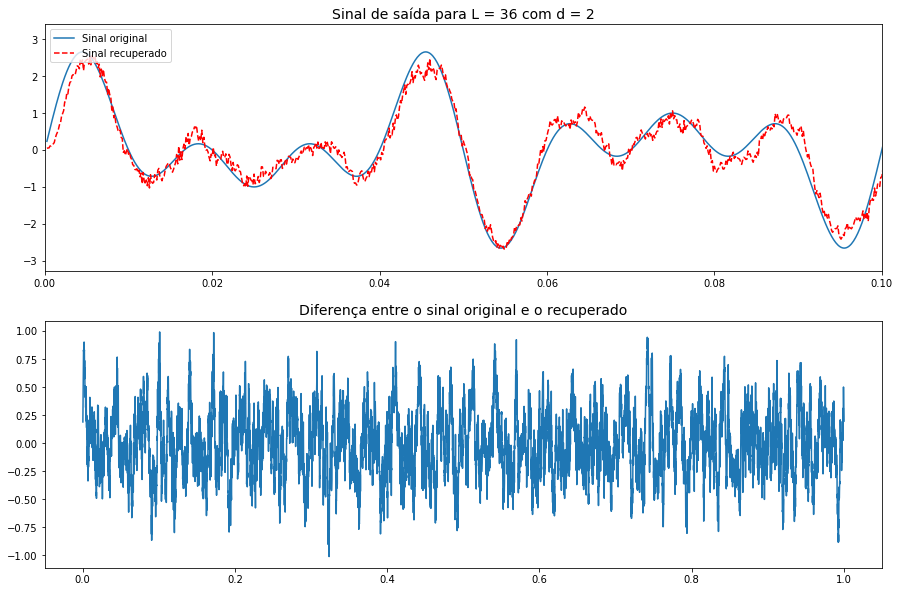

No handles with labels found to put in legend.


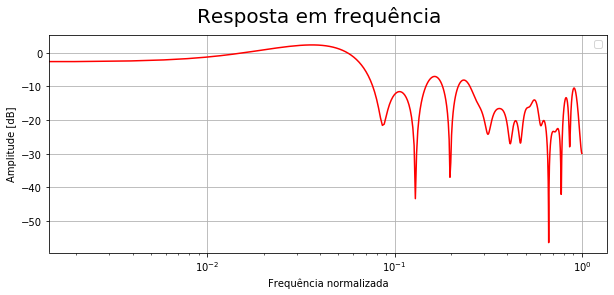

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


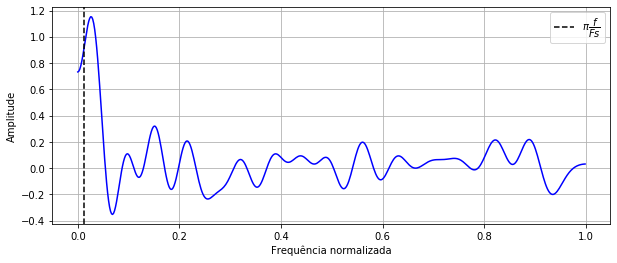

In [12]:
j = 1
num_param = num_params[34]

w, w_hist = Least_Mean_Square(x_atrasado[j], d[j], num_param)

# Construção da função de transferência do filtro FIR
num = [w[i][0] for i in range(0, len(w))]  # [w(0), w(1), w(2), ... , w(L-1)]

y = filter(num, [1], x_atrasado[j]) # Calculando a saída y = w*x(n-d)

print(np.var(y-x_original[j]))

plt.figure(figsize = [15, 10])
plt.subplot(2, 1, 1)
plt.plot(t_atrasado[j], x_original[j], label = 'Sinal original')
plt.plot(t_atrasado[j], y, 'r--', label = 'Sinal recuperado')
plt.xlim(0, 0.1)
plt.title('Sinal de saída para L = '+str(num_param)+' com d = '+str(atrasos[j]), fontsize = 14, )
plt.legend(loc = 'upper left')

plt.subplot(2, 1, 2)
plt.title('Diferença entre o sinal original e o recuperado', fontsize = 14, )
plt.plot(t_atrasado[j], x_original[j]-y)
#plt.ylim(-1.1, 1.1)
#plt.plot(t_atrasado, y, color = 'red', marker = '.')

plt.show()

W_z, H_z = signal.freqz(num, 1)

plt.figure(figsize = [10, 4])
plt.suptitle("Resposta em frequência", fontsize = 20)
plt.semilogx(W_z/np.pi, 20*np.log10(abs(H_z)), color = 'r')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequência normalizada')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = [10, 4])
plt.plot(W_z/np.pi, H_z, color = 'b')
plt.ylabel('Amplitude')
plt.xlabel('Frequência normalizada')
plt.axvline(x=(np.pi*f1/Fs), color = 'k', linestyle = '--', label = '$\pi \dfrac{f}{Fs}$')
plt.legend()
plt.grid()

plt.show()

In [0]:
sd.play(x_original[j], Fs)

In [0]:
sd.play(x+ruido, Fs)

In [0]:
sd.play(y, Fs)